# Computing velocities from positions


If you run this notebook on your own computer (recommended), need:
* julia (https://julialang.org/downloads/#official_binaries_for_manual_download)
* packages `PythonPlot` and `DelimitedFiles`, which you can install with the following julia commands:

```julia
using Pkg
Pkg.add(["PythonPlot","DelimitedFiles"])
```

The steps above are not necessary if you run on the server, but you need download your files after each lesson (as they are deleted). 

In [2]:
using PythonPlot
using Dates
using DelimitedFiles
using Statistics
using Downloads: download

This download an example file (a bike tour with the GPS tracking device)

In [3]:
filename = "track-drifter01-20221023T082329.txt"
if !isfile(filename)
    download("https://dox.ulg.ac.be/index.php/s/fMcSM6wLjXAVYLR/download",filename)
end

"track-drifter01-20221023T082329.txt"

The text file is a comma separated value file (CSV) where the columns are longitude, latitude, time

In [4]:
D = readdlm(filename,',');
time = DateTime.(D[:,1]);
lon = D[:,2]
lat = D[:,3];

Make a simple plot with the axis longitude and latitude

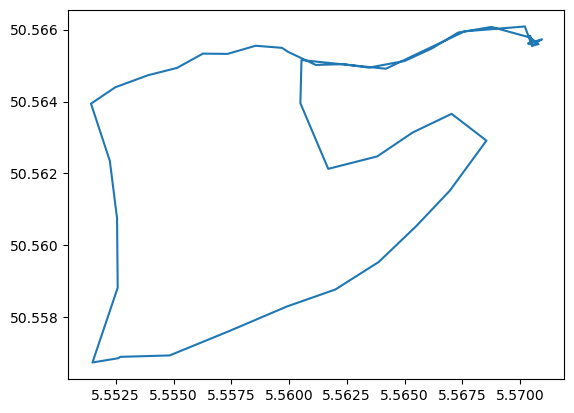

In [5]:
plot(lon,lat);

Make this plot nice with the base map from Open Street Map as explained [here](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Lon./lat._to_tile_numbers):

In [24]:
zoom = 13
lon_deg = lon[1]
lat_deg = lat[1]

# compute from longitude and latitude in degrees and the zoom level the 
# corresping tile indices.
function deg2num(lon_deg,lat_deg,zoom)
   lat_rad = pi/180 * lat_deg
   n = 2 ^ zoom
   xtile = floor(Int,n * ((lon_deg + 180) / 360))
   ytile = floor(Int,n * (1 - (log(tan(lat_rad) + sec(lat_rad)) / π)) / 2)
   return (xtile,ytile) 
end

xtile,ytile = deg2num(lon_deg,lat_deg,zoom)

(4222, 2758)

Compute the lonitude and latitude position from tile indices

In [7]:
function num2deg(xtile, ytile, zoom)
  n = 2.0^zoom
  lon_deg = xtile / n * 360 - 180
  lat_rad = atan(sinh(pi * (1 - 2 * ytile / n)))
  lat_deg = 180/pi * lat_rad
  return (lon_deg, lat_deg)
end

num2deg (generic function with 1 method)

longitude/latitude of the North-West corner 

In [9]:
lon0,lat1 = num2deg(xtile, ytile, zoom)

(5.537109375, 50.56928286558241)

longitude/latitude of the South-East corner

In [11]:
lon1,lat0 = num2deg(xtile+1, ytile+1, zoom)

(5.5810546875, 50.54136296522161)

Initial position of the GPS track 

In [12]:
lon[1],lat[1]

(5.570494, 50.565665)

URL of the image

In [25]:
URL = "https://tile.openstreetmap.org/$zoom/$xtile/$ytile.png"

"https://tile.openstreetmap.org/13/4222/2758.png"

Download image from Open Steet Map

In [26]:
img = imread(download(URL));

Plot the GPS track with the Open Steet Map basemap

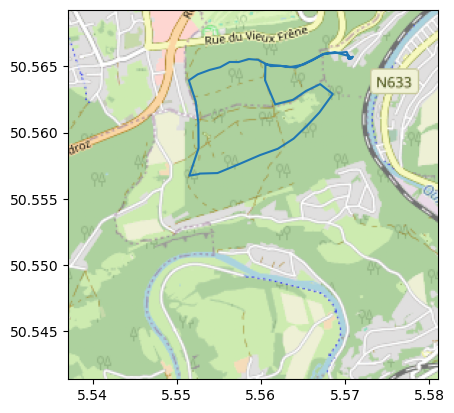

In [32]:
imshow(img,extent = (lon0,lon1,lat0,lat1), origin = "upper");
plot(lon,lat,"-")
gca().set_aspect(1/cosd(lat1));

The convert the position to in a velocity we need to Earth Radius

In [33]:
# Mean radius (http://en.wikipedia.org/wiki/Earth_radius)
R = 6371.009e3;

1 degree in the North-South direction corresponds approximately 111 km.

In [34]:
2*pi*R/360

111195.08372419141

In [36]:
time[1]

2022-10-23T08:23:29

In [37]:
time[2]

2022-10-23T08:24:35

`Dates.value` returns a duration in milliseconds

In [35]:
i=2
Dates.value(time[i+1]-time[i-1])

127000

compute the u (East-West) and v (North-South) velocity component

In [38]:
u = fill(NaN,size(lon))
v = fill(NaN,size(lat))

for i = 2:length(lon)-1
    # convert milliseconds to seconds
    DeltaT = Dates.value(time[i+1]-time[i-1]) / 1000
    v[i] = π*R/180 * (lat[i+1] - lat[i-1]) / DeltaT
    # cosd computes the cosinus of an angle in degree
    u[i] = π*R/180 * (lon[i+1] - lon[i-1]) / DeltaT   * cosd(lat[i])
end

speed = sqrt.(u.^2 + v.^2);

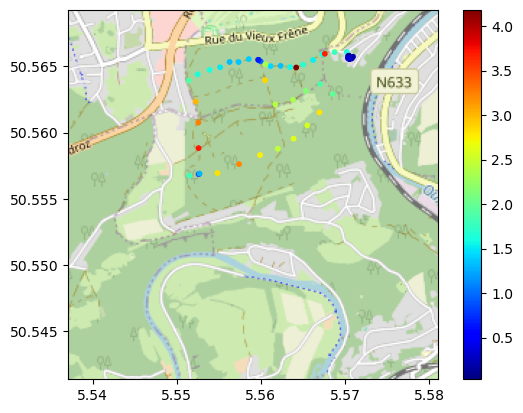

In [96]:
imshow(img,extent = (lon0,lon1,lat0,lat1), origin = "upper");
scatter(lon,lat,10,speed,cmap="jet"); colorbar()
gca().set_aspect(1/cosd(lat1));

Note it might be necessary to download multiple images tiles from Open Street Map. The zoom level (variable `zoom`) might need to be adjusted for your track.
Consider to use the bathymetry for example when plotting your drifter trajectory (using Open Street Map) .

## Bathymetry

Download the bathymetry as a NetCDF file:

In [74]:
bathname = "nwcorsica_bathymetry.nc";

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/9ZwWDbsTgCwgS90/download",bathname)
end

"nwcorsica_bathymetry.nc"

Install NCDatasets with if you using julia on your own computer (`NCDatasets` is already installed on the server):

```julia
using Pkg
Pkg.add("NCDatasets")
```

In [79]:
using NCDatasets
ds = NCDataset(bathname);

In [92]:
dss = NCDatasets.@select(ds, 8.7 <= lon <= 8.817 && 42.554 <= lat <= 42.6039)

Dataset: nwcorsica_bathymetry.nc
Group: /

Dimensions
   lat = 100
   lon = 234

Variables
  lat   (100)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     long_name            = Latitude
     standard_name        = latitude
     units                = degrees_north

  lon   (234)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     long_name            = Longitude
     standard_name        = longitude
     modulo               = 360.0
     units                = degrees_east

  bat   (234 × 100)
    Datatype:    Union{Missing, Float32}
    Dimensions:  lon × lat
    Attributes:
     long_name            = elevation above sea level
     standard_name        = height
     units                = meters
     _FillValue           = 1.0
     missing_value        = 1.0



Load the bathymetry and the corresponding longitude and latitude

In [93]:
bat_lon = dss["lon"][:];
bat_lat = dss["lat"][:];
bat = nomissing(dss["bat"][:,:],NaN);

Plot the bathymetry for the Bay of Calvi

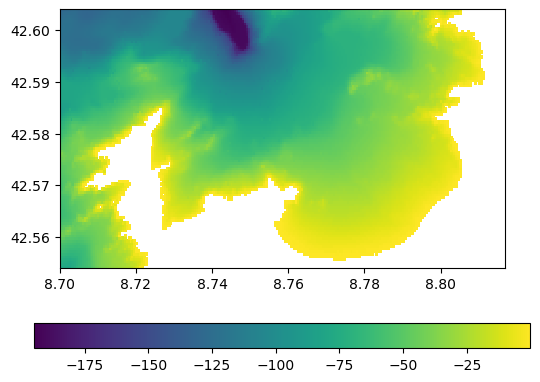

In [97]:
pcolor(bat_lon,bat_lat,bat'); colorbar(orientation="horizontal")
gca().set_aspect(1/cosd(mean(bat_lat)));